In [1]:
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
from upsetplot import UpSet

In [77]:
## Some utility functions
def get_circminer(circ_file, min_ccr=1):
    names=["chrom", "start", "end", "nccr", "type", "cons_splice", "splice", "pass", "supp_reads"]
    circrnas = pd.read_csv(circ_file, sep="\t", names=names)
    circrnas = circrnas[circrnas['nccr']>=min_ccr]
    return circrnas.sort_values(["chrom", "start"])

def get_circeplorer(circ_file, min_ccr=1):
    names=["chrom", "start", "end", "name", "score", "strand", "thickStart", 
           "thickEnd", "itemRgb", "exonCount", "exonSizes", "exonOffsets", 
           "readNumber", "circType", "geneName", "isoformName", "exonIndex/intronIndex", 
           "flankIntron"]
    circrnas = pd.read_csv(circ_file, sep="\t", names=names)
    circrnas['start'] = circrnas['start'] + 1
    circrnas = circrnas.rename(columns={"readNumber": "nccr"})
    circrnas = circrnas[circrnas['nccr']>=min_ccr]
    return circrnas.sort_values(["chrom", "start"])

def get_circeplorer2(circ_file, min_ccr=1):
    return get_circeplorer(circ_file, min_ccr)

def get_dcc(circ_file, min_ccr=1):
    circrnas = pd.read_csv(circ_file, sep="\t")
    circrnas = circrnas.rename(columns={"Chr": "chrom", "Start": "start", "End": "end", 
                                        "Chimeric.out.junction": "nccr"})
    circrnas = circrnas[circrnas['nccr']>=min_ccr]
    return circrnas.sort_values(["chrom", "start"])

def get_cirminer(circ_file, min_ccr=1):
    names=["chrom","start","end","nccr","type","cons_splice", "splice", "pass", "supp_reads"]
    circrnas = pd.read_csv(circ_file, sep="\t", names=names)
    circrnas = circrnas = circrnas[circrnas['nccr']>=min_ccr]
    return circrnas.sort_values(["chrom", "start"])

def set_key(record):
    return "-".join(map(str, [record["chrom"], record["start"], record["end"]]))

def get_keys(circrnas):
    circrnas_dict = defaultdict()
    for index, row in circrnas.iterrows():
        circrnas_dict[set_key(row)] = row
    circ_keys = set(circrnas_dict.keys())
    return circ_keys

def get_all_keys(circrnas):
    circ_keys = defaultdict()
    for tool, circs in circrnas.items():
        circ_keys[tool] = get_keys(circs)
    return circ_keys

def getRNaseCirc(condition, min_ccr=1):
    circexplorer = get_circeplorer("circrnas/"+condition+"/circexplorer_circ.txt", min_ccr)
    circexplorer2 = get_circeplorer2("circrnas/"+condition+"/circexplorer2_circrna.txt", min_ccr)
    dcc = get_dcc("circrnas/"+condition+"/dcc/CircRNACount", min_ccr)
    circminer = get_cirminer("circrnas/"+condition+"/circminer.circ_report", min_ccr=min_ccr)
    circrnas = {"CIRCexplorer": circexplorer, "CIRCexplorer2": circexplorer2, "DCC": dcc, 
                "Circminer": circminer}
    return circrnas

def get_support(circrnas):
    circ_keys = get_all_keys(circrnas)
    sorted_tools = sorted(circ_keys.keys())
    all_ids = set.union(*circ_keys.values())
    tool_support = []
    for circ in all_ids:
        counter = [True]
        for tool in sorted_tools:
            counter.append(True if circ in circ_keys[tool] else False)
        counter.append(circ)
        tool_support.append(counter)
    df = pd.DataFrame.from_records(tool_support,columns=["Union"] + sorted_tools +["id"])
    df = df.set_index(tools)
    return df

def get_depleted(circrnas, tools):
    before = get_all_keys(circrnas["HeLaR+"])
    after = get_all_keys(circrnas["HeLaR-"])
    sorted_tools = sorted(circrnas.keys())
    depletion = [defaultdict()]
    for tool in tools:
        depletion.append(len(after[tool] & before[tool]))
    return depletion 

In [58]:
treatments = ["HeLaR-", "HeLaR+"]
min_ccr = 2
rnas = defaultdict()
rnas["HeLaR-"] = getRNaseCirc("HeLaRminus", min_ccr=min_ccr)
rnas["HeLaR+"] = getRNaseCirc("HeLaRplus", min_ccr=min_ccr)

### Global statistics

In [60]:
tools = ["Circminer", "CIRCexplorer", "CIRCexplorer2", "DCC"]
treatments = ["HeLaR-", "HeLaR+"]
calls = defaultdict(list)
for condition in treatments:
    for tool in tools:
        calls[condition].append(len(rnas[condition][tool]))
calls['tool'] = tools
calls['No depleted'] = get_depleted(rnas, tools)

In [61]:
df = pd.DataFrame(calls).set_index("tool")
df

,HeLaR-,HeLaR+
tool,,
Circminer,6170,7518
CIRCexplorer,3446,5445
CIRCexplorer2,3446,5445
DCC,5343,6258


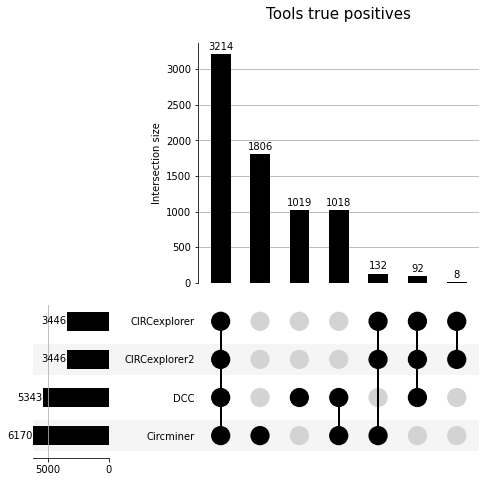

In [63]:
support = get_support(rnas["HeLaR-"])
fig = plt.figure(figsize=(100, 20))
upset = UpSet(support, subset_size='count', sort_by="cardinality", show_counts='%d', element_size=55)
upset.plot(fig = fig)
temp = plt.title("Tools true positives\n",fontsize=15)

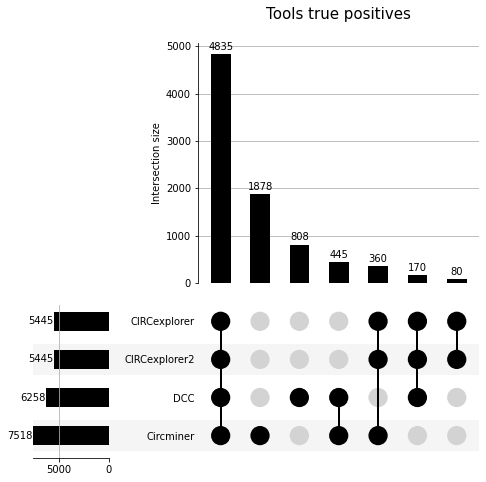

In [64]:
support = get_support(rnas["HeLaR+"])
fig = plt.figure(figsize=(100, 20))
upset = UpSet(support, subset_size='count', sort_by="cardinality", show_counts='%d', element_size=55)
upset.plot(fig = fig)
temp = plt.title("Tools true positives\n",fontsize=15)

In [66]:
before = get_all_keys(rnas["HeLaR-"])
after = get_all_keys(rnas["HeLaR+"])

In [74]:
print("%d and %d and %d" %(len(before["Circminer"]), len(after["Circminer"]), len(after["Circminer"] & before["Circminer"])))

6170 and 7518 and 3247


In [75]:
3247/6170

0.5262560777957861